# Report on Google Ads and its Effectiveness

In [1]:
import pandas as pd
import sys
import os
import parquet as pq
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
ytdf = pd.read_csv("data\yt_totals_locs.csv")
scdf = pd.read_csv("data\santa_clara_allday.csv")

## Exploratory Data Analysis

### Youtube Data

In [3]:
ytdf.columns

Index(['Campaign', 'Campaign bid strategy type', 'Campaign apps: active',
       'City (Geographic)', 'Currency code', 'Clicks', 'Impr.', 'CTR',
       'Avg. CPC', 'Cost', 'Impr. (Abs. Top) %', 'Impr. (Top) %',
       'Conversions', 'View-through conv.', 'Cost / conv.', 'Conv. rate'],
      dtype='object')

As one can see, we divided the ads into two main categories: the campaign it belonged to (e.g. Crypto Campaign #6), and the city it was set in (e.g. Menlo Park). From there, we have a variety of metrics that we can use as our KPIs.

In [4]:
ytdf.head()

,Campaign,Campaign bid strategy type,Campaign apps: active,City (Geographic),Currency code,Clicks,Impr.,CTR,Avg. CPC,Cost,Impr. (Abs. Top) %,Impr. (Top) %,Conversions,View-through conv.,Cost / conv.,Conv. rate
0,DAO Event Ad,Maximize clicks,0,Mountain View,USD,0,1,0.00%,--,0.00,100.00%,100.00%,0.0,0,--,0
1,DAO Event Ad,Maximize clicks,0,Campbell,USD,0,1,0.00%,--,0.00,0.00%,100.00%,0.0,0,--,0
2,Campaign Policy Ads,Maximize clicks,0,Portola Valley,USD,12,144,8.33%,3.31,39.73,44.83%,71.26%,0.0,0,--,0.00%
3,Campaign Policy Ads,Maximize clicks,0,Mission Viejo,USD,1,136,0.74%,3.56,3.56,44.83%,82.76%,0.0,0,--,0.00%
4,DAO Event Ad,Maximize clicks,0,Los Gatos,USD,0,1,0.00%,--,0.00,0,0,0.0,0,--,0


Here you can see a quick glimpse of what the table looks like, with the same campaign having multiple rows of data due to it being exposed to multiple cities. Since cities have varying populations, it would not make a lot of sense to compare their raw impressions and other metrics, but we can see what our costs add up to. 

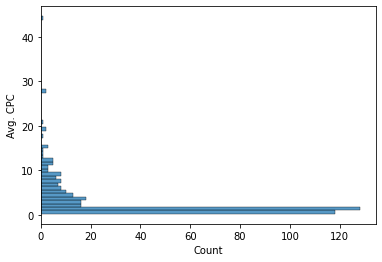

In [5]:
ytdf.replace(" --", np.nan)
ytdf['Avg. CPC'] = pd.to_numeric(ytdf['Avg. CPC'], errors='coerce')

fig, ax = plt.subplots()
ax = sns.histplot(data = ytdf, y = "Avg. CPC")

The histogram is extremely skewed right, which indicates that a good majority of our ads fall under a certain threshold, and once that threshold was passed we just gave up on it. 

Let's now look at the voter data.
### Voter Data

In [6]:
scdf = scdf.iloc[992:1191]
scdf.head()

,Date,County,ANNA G. ESHOO,RISHI KUMAR,PETER OHTAKI,RICHARD B. FOX,GREG LIN TANAKA,AJWANG RADING,BENJAMIN THOMAS SOLOMON,JOHN KARL FREDRICH,Registered Voters,Total,Voter Turnout
992,6/13/2022,2002,528,97,64,46,66,143,11,10,2603,965,37%
993,6/13/2022,2005,255,48,30,12,83,108,1,6,1423,543,38%
994,6/13/2022,2006,307,78,82,30,92,63,14,13,1886,679,36%
995,6/13/2022,2009,503,137,74,40,127,99,8,23,2959,1011,34%
996,6/13/2022,2013,488,86,84,45,136,86,5,7,2240,937,42%


In [7]:
scdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 992 to 1189
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Date                     198 non-null    object
 1   County                   198 non-null    int64 
 2   ANNA G. ESHOO            198 non-null    int64 
 3   RISHI KUMAR              198 non-null    int64 
 4   PETER OHTAKI             198 non-null    int64 
 5   RICHARD B. FOX           198 non-null    int64 
 6   GREG LIN TANAKA          198 non-null    int64 
 7   AJWANG RADING            198 non-null    int64 
 8   BENJAMIN THOMAS SOLOMON  198 non-null    int64 
 9   JOHN KARL FREDRICH       198 non-null    int64 
 10  Registered Voters        198 non-null    int64 
 11  Total                    198 non-null    int64 
 12  Voter Turnout            198 non-null    object
dtypes: int64(11), object(2)
memory usage: 20.2+ KB


The data essentially has each voting precinct's vote counts, the number of registered voters, and from that the total turnout. However, sometimes voter turnout is over 100%, which interferes with the data on the precinct level.
Lucky for us, we don't care about the precinct level, and unlucky for us, neither does Youtube.
From the site here: https://rovservices.sccgov.org/Home/IndexPost?selected=pm&nav=vc#, we link up the counties with their respective cities and sum up the data so that we can compare it to the YouTube Data.

## Merging Data

We will first create a new DataFrame to combine the two DataFrames together. 

List of cities is sourced from the same link above for list of Santa Clara County cities, and filtered by cities listed in https://www.gregtanaka.org

In [8]:
intervals = [2000,2200, 2300, 2500, 2700, 2800, 3400, 3700, 3800, 4600,5000, 6000, 7000, np.inf]
cities = ['Palo Alto', 'Los Altos Hills', 'Los Altos', 'Stanford', 'Los Gatos', 'Los Altos', 'Mountain View', 'Monte Sereno', 'Campbell','Saratoga','San Jose', 'Saratoga', 'San Jose' ]
scdf['City'] = pd.cut(scdf['County'], intervals, labels = cities, right = False, ordered = False )
scdf = scdf.groupby("City").sum()
scdf = scdf.reset_index(level=0)

In [9]:
valid = '1234567890.' #valid characters for a float
def sanitize(data):
    return float(''.join(filter(lambda char: char in valid, data)))


ytdf['Impr.'] = ytdf['Impr.'].apply(sanitize)
#ytdf['Impr.'] = pd.to_numeric(ytdf['Impr.'], errors='coerce')

ytdf['Clicks'] = ytdf['Clicks'].apply(sanitize)
#ytdf['Clicks'] = pd.to_numeric(ytdf['Clicks'], errors='coerce')

ytdf = ytdf.groupby("City (Geographic)").sum()
ytdf = ytdf.reset_index(level=0)

Let's see how our transformed data looks like now that we've grouped by city.

In [10]:
ytdf.head()

,City (Geographic),Campaign apps: active,Clicks,Impr.,Avg. CPC,Cost,Conversions,View-through conv.
0,Aberdeen,0,0.0,2.0,0.00,0.00,0.0,0
1,Abilene,0,0.0,1.0,0.00,0.00,0.0,0
2,Abington,0,1.0,1.0,1.06,1.06,1.0,0
3,Acworth,0,0.0,1.0,0.00,0.00,0.0,0
4,Aiea,0,0.0,1.0,0.00,0.00,0.0,0


For reference, Aberdeen is allegedly in Washington State, so as a side note we should probably really knock down targeting before we publish ads in the future.

In [11]:
scdf.head()

,City,County,ANNA G. ESHOO,RISHI KUMAR,PETER OHTAKI,RICHARD B. FOX,GREG LIN TANAKA,AJWANG RADING,BENJAMIN THOMAS SOLOMON,JOHN KARL FREDRICH,Registered Voters,Total
0,Campbell,53460,3626,1947,1036,854,517,461,125,157,25261,8723
1,Los Altos,48233,5219,1661,1489,560,655,577,107,81,25247,10349
2,Los Altos Hills,11387,1196,320,473,210,177,127,33,19,6507,2555
3,Los Gatos,30023,3466,1721,1201,650,314,268,138,69,22051,7827
4,Monte Sereno,15122,438,192,180,126,50,21,24,6,2683,1037


It seems like the YouTube data has a lot of cities that we don't care about, so let's filter it down to the cities we found in our voter data.

In [12]:
ytdf_filtered = ytdf[ytdf['City (Geographic)'].isin(cities)]

In [13]:
ytdf_filtered = ytdf_filtered.rename(columns={'City (Geographic)': 'City'}, errors = "raise")
ytdf_filtered.head()

,City,Campaign apps: active,Clicks,Impr.,Avg. CPC,Cost,Conversions,View-through conv.
208,Campbell,0,7596.0,1425879.0,53.00,7619.09,24.0,0
816,Los Altos,0,787.0,117073.0,8.06,358.55,5.0,0
817,Los Altos Hills,0,3236.0,755255.0,60.86,3992.10,11.0,2
820,Los Gatos,0,3469.0,753394.0,62.70,4300.65,9.0,1
960,Mountain View,0,6716.0,1446524.0,60.23,9221.95,25.0,5


In [14]:
finaldf = pd.merge(left = scdf, right = ytdf_filtered, on = ["City"] )

## Modeling

To model, we have to first consider the fact that since different cities have different populations, there would of course be a correlation between the number of impressions and the number of voters. So our question for this model would be,

Is there a correlation between the percent of voters won and the value Impressions/Registered voters? 
However, since there is a definite bound of percent voters won in [0,1], we opt to transform it to odds so that the bounds are (negative infinity, infinity). 

In [15]:
def odds(row):
    probability = row['GREG LIN TANAKA']/row['Total']
    return probability/(1-probability)

def ratio(row):
    return row['Impr.']/row['Registered Voters']

finaldf['Odds'] = finaldf.apply(lambda row: odds(row), axis=1)
finaldf['Impr/Registered'] = finaldf.apply(lambda row: ratio(row), axis=1)

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(finaldf)

              City  County  ANNA G. ESHOO  RISHI KUMAR  PETER OHTAKI  \
0         Campbell   53460           3626         1947          1036   
1        Los Altos   48233           5219         1661          1489   
2  Los Altos Hills   11387           1196          320           473   
3        Los Gatos   30023           3466         1721          1201   
4    Mountain View   51397           6102         2003          1071   
5        Palo Alto   43092           8364         1558          1343   
6         San Jose  692181          21563         8031          6697   
7         Saratoga   83608           3153         2349          1228   
8         Stanford    7624            794          103            43   

   RICHARD B. FOX  GREG LIN TANAKA  AJWANG RADING  BENJAMIN THOMAS SOLOMON  \
0             854              517            461                      125   
1             560              655            577                      107   
2             210              177           

## Linear Regression Model

<AxesSubplot:xlabel='Impr/Registered', ylabel='Odds'>

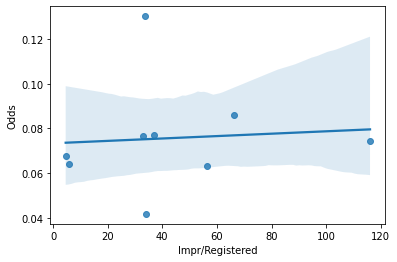

In [17]:
sns.regplot(x = "Impr/Registered", y = "Odds", data = finaldf)

In [18]:
x = finaldf['Impr/Registered'].to_numpy()
y = finaldf['Odds'].to_numpy()
# Compute Correlations
pr = st.pearsonr(x, y)
sr = st.spearmanr(x, y)

print(f'Pearsonr correlation for x,y = {pr[0]:5.3f}')
print(f'Spearmanr correlation for x,y = {sr[0]:5.3f}')

print('\nCovariance Matrix = \n', np.cov(x, y))

print('\nCorrelation Matrix = \n', np.corrcoef(x, y))

Pearsonr correlation for x,y = 0.076
Spearmanr correlation for x,y = 0.150

Covariance Matrix = 
 [[1.15360551e+03 6.17769847e-02]
 [6.17769847e-02 5.74039663e-04]]

Correlation Matrix = 
 [[1.         0.07591491]
 [0.07591491 1.        ]]


As shown in the model and the correlation matrix, though there does seem to be a general positive trend, the coefficient is still *incredibly* low, which seems to indicate that Google Advertising was not as effective as we thought. Nevertheless, it is probably unrealistic to see very high correlations, but something to keep in mind is the outliers.

We performed extremely well in Palo Alto, which can be attributed to the fact that Greg Tanaka is on its City Council. However, even with this buff, we still only finished third in terms of that city, with a great deficit behind Anna Eshoo and a ~1000 deficit behind Ajwang Rading.

We performed extremely poorly in Los Gatos; at this moment in time, I am not sure why our odds were so though, but that is definitely an area we should look to improve upon.

# Recommendations and Next Steps

Some conclusions we can make is to strictly limit the amount of ads we publish, since likely voters tend to be older with age and will be on their phones less than their younger counterparts. A lot of our campaign has been geared towards being progressive and very technological, especially with crypto being a significant part of the campaign. In the future, we can perhaps put more emphasis on issues that deal with older voters, such as healthcare, gun control, and inflation.
There is also a huge difference between the number of registered voters and the number of actual voters, which may be something to think about when creating a campaign strategy.
Lastly, it may be an interesting question on whether one should target defeating the Goliath (Anna Eshoo, in this case) or aiming for the run-off by focusing on the other candidates first, and then working on the Goliath afterwards.
Source for likely voters can be found here: https://www.ppic.org/publication/californias-likely-voters/

Some additional analysis can be done on the effectiveness of the crypto campaign alone, measuring success based on party leanings of each city, and spending and budgeting. 

# Extras

In [19]:
vdf = pd.read_csv('data/video_views.csv')

In [20]:
vdf = vdf.rename(columns = {'Locations': 'City'}, errors = 'raise')
vdf = pd.merge(left = scdf, right = vdf, on = ['City'])

In [21]:
vdf.head()

,City,County,ANNA G. ESHOO,RISHI KUMAR,PETER OHTAKI,RICHARD B. FOX,GREG LIN TANAKA,AJWANG RADING,BENJAMIN THOMAS SOLOMON,JOHN KARL FREDRICH,Registered Voters,Total,Views
0,Campbell,53460,3626,1947,1036,854,517,461,125,157,25261,8723,16432
1,Los Altos,48233,5219,1661,1489,560,655,577,107,81,25247,10349,58
2,Los Altos Hills,11387,1196,320,473,210,177,127,33,19,6507,2555,6900
3,Los Gatos,30023,3466,1721,1201,650,314,268,138,69,22051,7827,7370
4,Mountain View,51397,6102,2003,1071,554,856,1051,148,150,39027,11935,20778


In [22]:
def viewers(row):
    return row['Views']/row['Registered Voters']
vdf['View/Voter'] = vdf.apply(lambda row: viewers(row), axis=1)
vdf['Odds'] = finaldf['Odds']

<AxesSubplot:xlabel='View/Voter', ylabel='Odds'>

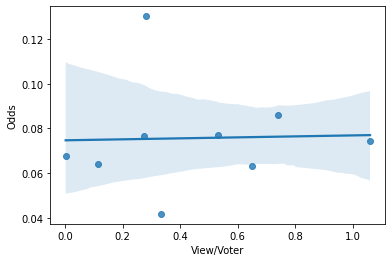

In [23]:
sns.regplot(x = "View/Voter", y = "Odds", data = vdf)

In [24]:
x = vdf['View/Voter'].to_numpy()
y = vdf['Odds'].to_numpy()
# Compute Correlations
pr = st.pearsonr(x, y)
sr = st.spearmanr(x, y)

print(f'Pearsonr correlation for x,y = {pr[0]:5.3f}')
print(f'Spearmanr correlation for x,y = {sr[0]:5.3f}')

print('\nCovariance Matrix = \n', np.cov(x, y))

print('\nCorrelation Matrix = \n', np.corrcoef(x, y))

Pearsonr correlation for x,y = 0.031
Spearmanr correlation for x,y = 0.150

Covariance Matrix = 
 [[0.11111683 0.00024375]
 [0.00024375 0.00057404]]

Correlation Matrix = 
 [[1.         0.03051999]
 [0.03051999 1.        ]]


In [25]:
finaldf.to_csv("data/santa_clara_yt.csv")